# Non supervised learning

> Reminder: *In general Learning from Data is a scientific discipline that is concerned with the design and development of algorithms that allow computers to infer (from data) a model that allows compact representation (unsupervised learning) and/or good generalization (supervised learning).*

## Autoencoders

Suppose we have only a set of unlabeled training examples $x_1,x_2,x_3, \dots $, where $x_i \in \mathbb{R}^n$. 

An autoencoder neural network is an *unsupervised learning* algorithm that applies backpropagation and uses a loss function that is optimal when setting the target values to be equal to the inputs, $y_i=x_i$.

Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. 

To build an autoencoder, you need three things: an **encoding function**, a **decoding function**, and a **distance function** to measure the amount of information loss between your data and the decompressed representation.

<center>
<img src="images/autoencoder.jpg" alt="" style="width: 700px;"/>
Source: https://blog.keras.io/building-autoencoders-in-keras.html
</center>

The ideal autoencoder model balances the following:

+ Sensitive to the inputs enough to accurately build a reconstruction.
+ Insensitive enough to the inputs that the model doesn't simply memorize or overfit the training data.

Two practical applications of autoencoders are **data denoising**, and **dimensionality reduction** for data visualization. 

With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other linear techniques.

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [1]:
# Source: Adapted from https://blog.keras.io/building-autoencoders-in-keras.html

from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations       
encoding_dim = 32  # 32 floats -> compression of factor 24.5, 
                   # assuming the input is 784 floats

input_img = Input(shape=(784,))

# encoded representation of the input
encoding_layer = Dense(encoding_dim, 
                       activation='relu')
encoded = encoding_layer(input_img)

# lossy reconstruction of the input
decoding_layer = Dense(784, 
                       activation='sigmoid')
decoded = decoding_layer(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Let's also create a separate encoder model and a separate decoder model:

In [0]:
# this model maps an input to its encoded representation
encoding_model = Model(input_img, encoded)

# create a placeholder for an encoded input
# and create the decoder model
encoded_input = Input(shape=(encoding_dim,))
decoding_model = Model(encoded_input, decoding_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

Let's prepare our input data. 

In [3]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, 
                x_train,
                epochs=15,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

11493376/11490434 [==============================] - 3s 0us/step
(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0706 - val_loss: 0.0414
Epoch 2/15
60000/60000 [==============================] - 1s 24us/step - loss: 0.0350 - val_loss: 0.0293
Epoch 3/15
60000/60000 [==============================] - 1s 24us/step - loss: 0.0264 - val_loss: 0.0232
Epoch 4/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0217 - val_loss: 0.0195
Epoch 5/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0185 - val_loss: 0.0168
Epoch 6/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0162 - val_loss: 0.0149
Epoch 7/15
14848/60000 [======>.......................] - ETA: 0s - loss: 0.0151

60000/60000 [==============================] - 1s 23us/step - loss: 0.0145 - val_loss: 0.0135
Epoch 8/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0133 - val_loss: 0.0126
Epoch 9/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0124 - val_loss: 0.0117
Epoch 10/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0118 - val_loss: 0.0112
Epoch 11/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0114 - val_loss: 0.0108
Epoch 12/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0111 - val_loss: 0.0106
Epoch 13/15
60000/60000 [==============================] - 1s 24us/step - loss: 0.0109 - val_loss: 0.0104
Epoch 14/15
60000/60000 [==============================] - 1s 23us/step - loss: 0.0108 - val_loss: 0.0103
Epoch 15/15
19968/60000 [========>.....................] - ETA: 0s - loss: 0.0107

60000/60000 [==============================] - 1s 23us/step - loss: 0.0107 - val_loss: 0.0103


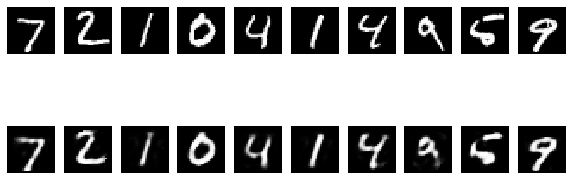

In [4]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoding_model.predict(x_test)
decoded_imgs = decoding_model.predict(encoded_imgs)

import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding depth and sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32 neurons). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). 

Another way to constrain the representations to be compact is to add a **sparsity contraint** on the activity of the hidden representations, so fewer units would "fire" at a given time. 

For any given observation, we'll encourage our network to learn an encoding and decoding which only relies on activating a small number of neurons. It's worth noting that this is a different approach towards regularization, as we normally regularize the weights of a network, not the activations.

In Keras, this can be done by adding an ``activity_regularizer`` to our Dense layer:

In [5]:
#autoencoder.reset_states()
#encoder.reset_states()
#decoder.reset_states()

from keras import regularizers
from keras import optimizers
from keras.regularizers import l2, l1
from keras.layers import Input, Dense
from keras.models import Model

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu',activity_regularizer=l1(10e-5))(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', 
                    loss='binary_crossentropy',
                    )

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.5734 - val_loss: 0.2777
Epoch 2/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2666 - val_loss: 0.2637
Epoch 3/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2636 - val_loss: 0.2631
Epoch 4/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2632 - val_loss: 0.2629
Epoch 5/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2631 - val_loss: 0.2627
Epoch 6/100
50688/60000 [========================>.....] - ETA: 0s - loss: 0.2629

60000/60000 [==============================] - 2s 41us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 7/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 8/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2630 - val_loss: 0.2627
Epoch 9/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 10/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 11/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 12/100
31232/60000 [==============>...............] - ETA: 1s - loss: 0.2626

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 13/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 14/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 15/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 16/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 17/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 18/100
30208/60000 [==============>...............] - ETA: 1s - loss: 0.2626

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 19/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 20/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 21/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 22/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 23/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 24/100
26624/60000 [============>.................] - ETA: 1s - loss: 0.2628

60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 25/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 26/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 27/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 28/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 29/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 30/100
30208/60000 [==============>...............] - ETA: 1s - loss: 0.2626

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 31/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 32/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 33/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 34/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 35/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 36/100
28160/60000 [=============>................] - ETA: 1s - loss: 0.2631

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 37/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 38/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 39/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 40/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 41/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 42/100
28928/60000 [=============>................] - ETA: 1s - loss: 0.2628

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 43/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 44/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 45/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 46/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 47/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 48/100
29952/60000 [=============>................] - ETA: 1s - loss: 0.2630

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 49/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 50/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 51/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 52/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 53/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 54/100
25856/60000 [===========>..................] - ETA: 1s - loss: 0.2631

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 55/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 56/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 57/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 58/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 59/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 60/100
24320/60000 [===========>..................] - ETA: 1s - loss: 0.2631

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 61/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 62/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 63/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 64/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 65/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 66/100
22784/60000 [==========>...................] - ETA: 1s - loss: 0.2626

60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 67/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 68/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 69/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 70/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 71/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 72/100
25344/60000 [===========>..................] - ETA: 1s - loss: 0.2631

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 73/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 74/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 75/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 76/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 77/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 78/100
28416/60000 [=============>................] - ETA: 1s - loss: 0.2631

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 79/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 80/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 81/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2627
Epoch 82/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 83/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 84/100
24064/60000 [===========>..................] - ETA: 1s - loss: 0.2630

60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 85/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 86/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 87/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 88/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2625
Epoch 89/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 90/100
27904/60000 [============>.................] - ETA: 1s - loss: 0.2630

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 91/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 92/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 93/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 94/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2628 - val_loss: 0.2626
Epoch 95/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 96/100
25600/60000 [===========>..................] - ETA: 1s - loss: 0.2625

60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 97/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 98/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 99/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2629 - val_loss: 0.2626
Epoch 100/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.2629 - val_loss: 0.2626


## Convolutional Autoencoders

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. 

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), padding="same", activation="relu")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), padding="same", activation="relu")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding="same", activation="relu")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

# at this point the representation is (28, 28, 1) i.e. 784-dimensional

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

In [8]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 184us/step - loss: 0.2137 - val_loss: 0.1599
Epoch 2/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1546 - val_loss: 0.1444
Epoch 3/50
46336/60000 [======================>.......] - ETA: 2s - loss: 0.1415

60000/60000 [==============================] - 10s 165us/step - loss: 0.1405 - val_loss: 0.1365
Epoch 4/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1328 - val_loss: 0.1276
Epoch 5/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1283 - val_loss: 0.1247
Epoch 6/50
23808/60000 [==========>...................] - ETA: 5s - loss: 0.1262

60000/60000 [==============================] - 10s 167us/step - loss: 0.1249 - val_loss: 0.1278
Epoch 7/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1224 - val_loss: 0.1217
Epoch 8/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1205 - val_loss: 0.1229
Epoch 9/50
19968/60000 [========>.....................] - ETA: 6s - loss: 0.1192

60000/60000 [==============================] - 10s 166us/step - loss: 0.1187 - val_loss: 0.1129
Epoch 10/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1169 - val_loss: 0.1154
Epoch 11/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1156 - val_loss: 0.1126
Epoch 12/50
18176/60000 [========>.....................] - ETA: 6s - loss: 0.1146

60000/60000 [==============================] - 10s 164us/step - loss: 0.1145 - val_loss: 0.1119
Epoch 13/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1132 - val_loss: 0.1117
Epoch 14/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1122 - val_loss: 0.1081
Epoch 15/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1116

60000/60000 [==============================] - 10s 165us/step - loss: 0.1115 - val_loss: 0.1093
Epoch 16/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1106 - val_loss: 0.1114
Epoch 17/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1098 - val_loss: 0.1094
Epoch 18/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1097

60000/60000 [==============================] - 10s 168us/step - loss: 0.1095 - val_loss: 0.1094
Epoch 19/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1090 - val_loss: 0.1068
Epoch 20/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1083 - val_loss: 0.1073
Epoch 21/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1084

60000/60000 [==============================] - 10s 166us/step - loss: 0.1083 - val_loss: 0.1068
Epoch 22/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1078 - val_loss: 0.1099
Epoch 23/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.1071 - val_loss: 0.1083
Epoch 24/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1070

60000/60000 [==============================] - 10s 166us/step - loss: 0.1066 - val_loss: 0.1084
Epoch 25/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1062 - val_loss: 0.1044
Epoch 26/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1056 - val_loss: 0.1026
Epoch 27/50
18176/60000 [========>.....................] - ETA: 6s - loss: 0.1053

60000/60000 [==============================] - 10s 166us/step - loss: 0.1053 - val_loss: 0.1054
Epoch 28/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1052 - val_loss: 0.1057
Epoch 29/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1049 - val_loss: 0.1051
Epoch 30/50
17792/60000 [=======>......................] - ETA: 6s - loss: 0.1051

60000/60000 [==============================] - 10s 165us/step - loss: 0.1045 - val_loss: 0.1023
Epoch 31/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1041 - val_loss: 0.1030
Epoch 32/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1040 - val_loss: 0.1018
Epoch 33/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1039

60000/60000 [==============================] - 10s 166us/step - loss: 0.1038 - val_loss: 0.1031
Epoch 34/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1037 - val_loss: 0.1008
Epoch 35/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1033 - val_loss: 0.1019
Epoch 36/50
17920/60000 [=======>......................] - ETA: 6s - loss: 0.1029

60000/60000 [==============================] - 10s 166us/step - loss: 0.1031 - val_loss: 0.1048
Epoch 37/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1029 - val_loss: 0.1008
Epoch 38/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1025 - val_loss: 0.1007
Epoch 39/50
18560/60000 [========>.....................] - ETA: 6s - loss: 0.1032

60000/60000 [==============================] - 10s 167us/step - loss: 0.1024 - val_loss: 0.1015
Epoch 40/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1023 - val_loss: 0.1039
Epoch 41/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1022 - val_loss: 0.1019
Epoch 42/50
18432/60000 [========>.....................] - ETA: 6s - loss: 0.1014

60000/60000 [==============================] - 10s 166us/step - loss: 0.1018 - val_loss: 0.1021
Epoch 43/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1018 - val_loss: 0.1009
Epoch 44/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.1017 - val_loss: 0.1021
Epoch 45/50
18560/60000 [========>.....................] - ETA: 6s - loss: 0.1014

60000/60000 [==============================] - 10s 166us/step - loss: 0.1012 - val_loss: 0.1018
Epoch 46/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1014 - val_loss: 0.1002
Epoch 47/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1011 - val_loss: 0.1017
Epoch 48/50
18560/60000 [========>.....................] - ETA: 6s - loss: 0.1014

60000/60000 [==============================] - 10s 166us/step - loss: 0.1012 - val_loss: 0.1024
Epoch 49/50
60000/60000 [==============================] - 10s 165us/step - loss: 0.1008 - val_loss: 0.0989
Epoch 50/50
60000/60000 [==============================] - 10s 166us/step - loss: 0.1006 - val_loss: 0.0990


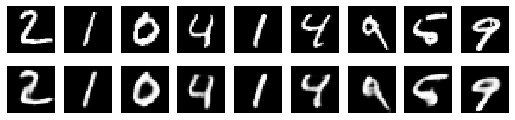

In [9]:
decoded_imgs = autoencoder.predict(x_test)

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(10, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising autoencoders

Another approach towards developing a generalizable model is to slightly corrupt the input data but still maintain the uncorrupted data as our target output.

With this approach, our model isn't able to simply develop a mapping which memorizes the training data because our input and target output are no longer the same.

<center>
<img src="images/denoised_digits.png" alt="" style="width: 700px;"/> 
(Source: https://blog.keras.io/building-autoencoders-in-keras.html)
</center>

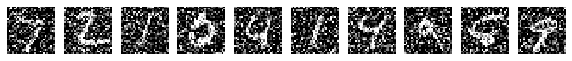

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(10, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(784, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

model.fit(x_train_noisy, x_train, 
          epochs=100,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.2645 - val_loss: 0.1968
Epoch 2/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1776 - val_loss: 0.1653
Epoch 3/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1606 - val_loss: 0.1555
Epoch 4/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1531 - val_loss: 0.1492
Epoch 5/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1481 - val_loss: 0.1453
Epoch 6/100
58624/60000 [============================>.] - ETA: 0s - loss: 0.1436

60000/60000 [==============================] - 2s 40us/step - loss: 0.1436 - val_loss: 0.1411
Epoch 7/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1399 - val_loss: 0.1376
Epoch 8/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1370 - val_loss: 0.1351
Epoch 9/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1349 - val_loss: 0.1341
Epoch 10/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1331 - val_loss: 0.1315
Epoch 11/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1315 - val_loss: 0.1309
Epoch 12/100
38400/60000 [==================>...........] - ETA: 0s - loss: 0.1302

60000/60000 [==============================] - 2s 40us/step - loss: 0.1302 - val_loss: 0.1294
Epoch 13/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1290 - val_loss: 0.1282
Epoch 14/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1280 - val_loss: 0.1282
Epoch 15/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1271 - val_loss: 0.1267
Epoch 16/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1262 - val_loss: 0.1270
Epoch 17/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1255 - val_loss: 0.1258
Epoch 18/100
32768/60000 [===============>..............] - ETA: 1s - loss: 0.1245

60000/60000 [==============================] - 2s 40us/step - loss: 0.1247 - val_loss: 0.1250
Epoch 19/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1239 - val_loss: 0.1241
Epoch 20/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1233 - val_loss: 0.1236
Epoch 21/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1228 - val_loss: 0.1230
Epoch 22/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1221 - val_loss: 0.1230
Epoch 23/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1215 - val_loss: 0.1223
Epoch 24/100
26368/60000 [============>.................] - ETA: 1s - loss: 0.1208

60000/60000 [==============================] - 2s 41us/step - loss: 0.1210 - val_loss: 0.1221
Epoch 25/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1205 - val_loss: 0.1220
Epoch 26/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1202 - val_loss: 0.1210
Epoch 27/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1198 - val_loss: 0.1205
Epoch 28/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1195 - val_loss: 0.1209
Epoch 29/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1191 - val_loss: 0.1200
Epoch 30/100
30976/60000 [==============>...............] - ETA: 1s - loss: 0.1182

60000/60000 [==============================] - 2s 40us/step - loss: 0.1188 - val_loss: 0.1202
Epoch 31/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1186 - val_loss: 0.1198
Epoch 32/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1183 - val_loss: 0.1196
Epoch 33/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1181 - val_loss: 0.1192
Epoch 34/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1177 - val_loss: 0.1188
Epoch 35/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1175 - val_loss: 0.1194
Epoch 36/100
32768/60000 [===============>..............] - ETA: 1s - loss: 0.1171

60000/60000 [==============================] - 2s 40us/step - loss: 0.1172 - val_loss: 0.1191
Epoch 37/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1170 - val_loss: 0.1181
Epoch 38/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1167 - val_loss: 0.1180
Epoch 39/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1166 - val_loss: 0.1180
Epoch 40/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1164 - val_loss: 0.1180
Epoch 41/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1161 - val_loss: 0.1180
Epoch 42/100
31488/60000 [==============>...............] - ETA: 1s - loss: 0.1157

60000/60000 [==============================] - 2s 40us/step - loss: 0.1160 - val_loss: 0.1178
Epoch 43/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1157 - val_loss: 0.1178
Epoch 44/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1156 - val_loss: 0.1176
Epoch 45/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1154 - val_loss: 0.1171
Epoch 46/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1152 - val_loss: 0.1169
Epoch 47/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1151 - val_loss: 0.1172
Epoch 48/100
28160/60000 [=============>................] - ETA: 1s - loss: 0.1149

60000/60000 [==============================] - 2s 40us/step - loss: 0.1149 - val_loss: 0.1167
Epoch 49/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1147 - val_loss: 0.1168
Epoch 50/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1147 - val_loss: 0.1166
Epoch 51/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1145 - val_loss: 0.1167
Epoch 52/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1143 - val_loss: 0.1165
Epoch 53/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1142 - val_loss: 0.1162
Epoch 54/100
32768/60000 [===============>..............] - ETA: 1s - loss: 0.1140

60000/60000 [==============================] - 2s 40us/step - loss: 0.1140 - val_loss: 0.1164
Epoch 55/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1140 - val_loss: 0.1166
Epoch 56/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1139 - val_loss: 0.1158
Epoch 57/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1138 - val_loss: 0.1160
Epoch 58/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1137 - val_loss: 0.1160
Epoch 59/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1136 - val_loss: 0.1158
Epoch 60/100
29696/60000 [=============>................] - ETA: 1s - loss: 0.1132

60000/60000 [==============================] - 2s 41us/step - loss: 0.1134 - val_loss: 0.1162
Epoch 61/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1134 - val_loss: 0.1159
Epoch 62/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1133 - val_loss: 0.1158
Epoch 63/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1132 - val_loss: 0.1156
Epoch 64/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1131 - val_loss: 0.1157
Epoch 65/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1129 - val_loss: 0.1156
Epoch 66/100
32512/60000 [===============>..............] - ETA: 1s - loss: 0.1128

60000/60000 [==============================] - 2s 40us/step - loss: 0.1129 - val_loss: 0.1159
Epoch 67/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1129 - val_loss: 0.1155
Epoch 68/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1128 - val_loss: 0.1152
Epoch 69/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1128 - val_loss: 0.1151
Epoch 70/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1126 - val_loss: 0.1160
Epoch 71/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.1125 - val_loss: 0.1155
Epoch 72/100
32000/60000 [===============>..............] - ETA: 1s - loss: 0.1124

60000/60000 [==============================] - 2s 40us/step - loss: 0.1125 - val_loss: 0.1153
Epoch 73/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1124 - val_loss: 0.1153
Epoch 74/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1124 - val_loss: 0.1151
Epoch 75/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1124 - val_loss: 0.1155
Epoch 76/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1122 - val_loss: 0.1150
Epoch 77/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1122 - val_loss: 0.1152
Epoch 78/100
32512/60000 [===============>..............] - ETA: 1s - loss: 0.1121

60000/60000 [==============================] - 2s 40us/step - loss: 0.1121 - val_loss: 0.1151
Epoch 79/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1121 - val_loss: 0.1156
Epoch 80/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1121 - val_loss: 0.1149
Epoch 81/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1119 - val_loss: 0.1148
Epoch 82/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1119 - val_loss: 0.1147
Epoch 83/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1118 - val_loss: 0.1146
Epoch 84/100
30976/60000 [==============>...............] - ETA: 1s - loss: 0.1117

60000/60000 [==============================] - 2s 40us/step - loss: 0.1118 - val_loss: 0.1145
Epoch 85/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1117 - val_loss: 0.1143
Epoch 86/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1116 - val_loss: 0.1146
Epoch 87/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1116 - val_loss: 0.1145
Epoch 88/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1115 - val_loss: 0.1148
Epoch 89/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1115 - val_loss: 0.1143
Epoch 90/100
31488/60000 [==============>...............] - ETA: 1s - loss: 0.1114

60000/60000 [==============================] - 2s 40us/step - loss: 0.1114 - val_loss: 0.1145
Epoch 91/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1115 - val_loss: 0.1143
Epoch 92/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1114 - val_loss: 0.1142
Epoch 93/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1112 - val_loss: 0.1144
Epoch 94/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1113 - val_loss: 0.1143
Epoch 95/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1111 - val_loss: 0.1146
Epoch 96/100
32000/60000 [===============>..............] - ETA: 1s - loss: 0.1111

60000/60000 [==============================] - 2s 40us/step - loss: 0.1112 - val_loss: 0.1142
Epoch 97/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1112 - val_loss: 0.1145
Epoch 98/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1110 - val_loss: 0.1144
Epoch 99/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1110 - val_loss: 0.1146
Epoch 100/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.1110 - val_loss: 0.1142


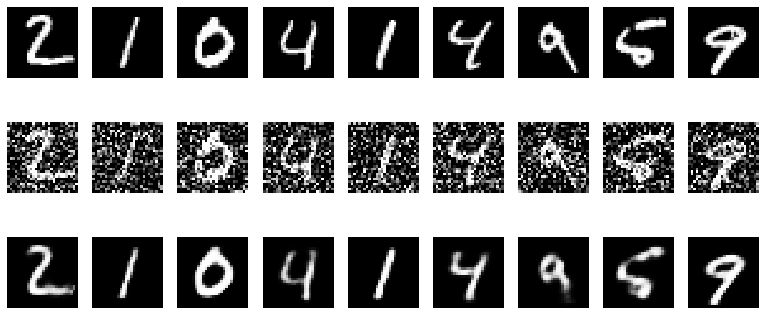

In [14]:
decoded_imgs = model.predict(x_test)
n = 10
plt.figure(figsize=(15, 6))
for i in range(1, n):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoders

A variational autoencoder is an autoencoder that adds probabilistic constraints on the representations being learned. 

> When using probabilistic models, **compressed representation** is called **latent variable model**. 

So, instead of learning a function this model is learning a probabilistic distribution function that models your data.

> Why? Standard autoencoders are not suited to work as a generative model. If you pick a random value for your decoder you won't get necessarily a good reconstruction: the value can far away from any previous value the network has seen before! That's why attaching a probabilistic model to the compressed representation is a good idea! 

For sake of simplicity, let's use a standard normal distribution to define the distribution of inputs ($\mathbf V$) the decoder will receive. 

The architecture of a variational autoencoder (VAE) is thus:

<center>
<img src="images/vae1.png" alt="" style="width: 300px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

We want the decoder to take any point taken from a standard normal distribution to return a reasonable element of our dataset:

<center>
<img src="images/vae2.png" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

Let's consider the encoder role in this architecture. 

In a traditional autoencoder, the encoder model takes a sample from data and returns a single point in the latent space, which is then passed to the decoder.

In VAE the encoder instead produces (the parameters of) a probability distribution in the latent space:

<center>
<img src="images/vae3.png" alt="" style="width: 500px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

These distributions are (non standard) Gaussians of the same dimensionality as the latent space. 

### Implementation

First, let’s implement the encoder net, which takes input $X$ and outputs two things: $\mu(X)$ and $\Sigma(X)$, the parameters of the Gaussian. Our encoder will be based in a convolutional neural net. 

Our latent variable is two dimensional, so that we could easily visualize it.

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

# encoder

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Using TensorFlow backend.


Up to now we have an encoder that takes images and produce (the parameters of) a pdf in the latent space.  

The decoder takes points in the latent space and return reconstructions.

How do we connect both models? By sampling from the produced distribution!


<center>
<img src="images/vae4.png" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To this end we will implement a *random variate reparameterisation*: the substitution of a random variable by a deterministic transformation of a simpler random variable.

There are several methods by which non-uniform random numbers, or random variates, can be generated. The most popular methods are the **one-liners**, which give us the simple tools to generate random variates in one line of code, following the classic paper by Luc Devroye (Luc Devroye, Random variate generation in one line of code, Proceedings of the 28th conference on Winter simulation, 1996).

In the case of a Gaussian, we can use the following algorithm:
+ Generate $\epsilon \sim \mathcal{N}(0;1)$.
+ Compute a sample from $\mathcal{N}(\mu; RR^T)$ as $\mu + R \epsilon$.

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

Now we can create the decoder net. In order to be coherent with our previous definitions, we must assure that points sampled fron the latent space fit a standard normal distribition, but the encoder is producing non standard normal distributions. So, we must add a constraint for getting something like this:

<center>
<img src="images/vae5.png" alt="" style="width: 700px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

In order to impose this constraint in the loss function by using the Kullback-Leibler divergence.

> The Kullback–Leibler divergence is a measure of how one probability distribution diverges from a second expected probability distribution. 
For discrete probability distributions $P$ and $Q$, the Kullback–Leibler divergence from $Q$ to $P$ is defined to be
$$ D_{\mathrm {KL} }(P\|Q)=\sum _{i}P(i)\,\log {\frac {P(i)}{Q(i)}}. $$

The rest of the loss function must take into account the "reconstruction" error.


In [4]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


### Training a VAE

How do we train a model that have a sampling step? 

<center>
<img src="images/vae_sampling.png" alt="" style="width: 800px;"/> 
</center>

In fact this is not a problem! By using the *one-liner* method for sampling we have expressed the latent distribution in a way that its parameters are factored out of the parameters of the random variable so that backpropagation can be used to find the optimal parameters of the latent distribution. For this reason this method is called *reparametrization trick*.

By using this trick we can train end-to-end a VAE with backpropagation.

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
12112/60000 [=====>........................] - ETA: 5:41 - loss: 0.1852

60000/60000 [==============================] - 451s 8ms/step - loss: 0.1857 - val_loss: 0.1857


Epoch 2/10
59984/60000 [============================>.] - ETA: 0s - loss: 0.1855

60000/60000 [==============================] - 450s 7ms/step - loss: 0.1855 - val_loss: 0.1874
Epoch 3/10
 9024/60000 [===>..........................] - ETA: 6:20 - loss: 0.1847

60000/60000 [==============================] - 471s 8ms/step - loss: 0.1854 - val_loss: 0.1861


Epoch 4/10
59984/60000 [============================>.] - ETA: 0s - loss: 0.1854

60000/60000 [==============================] - 473s 8ms/step - loss: 0.1854 - val_loss: 0.1887
Epoch 5/10
 9024/60000 [===>..........................] - ETA: 6:23 - loss: 0.1854

60000/60000 [==============================] - 470s 8ms/step - loss: 0.1853 - val_loss: 0.1859


Epoch 6/10
59984/60000 [============================>.] - ETA: 0s - loss: 0.1851

60000/60000 [==============================] - 467s 8ms/step - loss: 0.1851 - val_loss: 0.1851
Epoch 7/10
 9024/60000 [===>..........................] - ETA: 6:14 - loss: 0.1846

60000/60000 [==============================] - 451s 8ms/step - loss: 0.1851 - val_loss: 0.1876


Epoch 8/10
59984/60000 [============================>.] - ETA: 0s - loss: 0.1851

60000/60000 [==============================] - 449s 7ms/step - loss: 0.1851 - val_loss: 0.1867
Epoch 9/10
 9024/60000 [===>..........................] - ETA: 6:09 - loss: 0.1848

60000/60000 [==============================] - 450s 8ms/step - loss: 0.1849 - val_loss: 0.1846


Epoch 10/10
59984/60000 [============================>.] - ETA: 0s - loss: 0.1850

60000/60000 [==============================] - 470s 8ms/step - loss: 0.1850 - val_loss: 0.1845


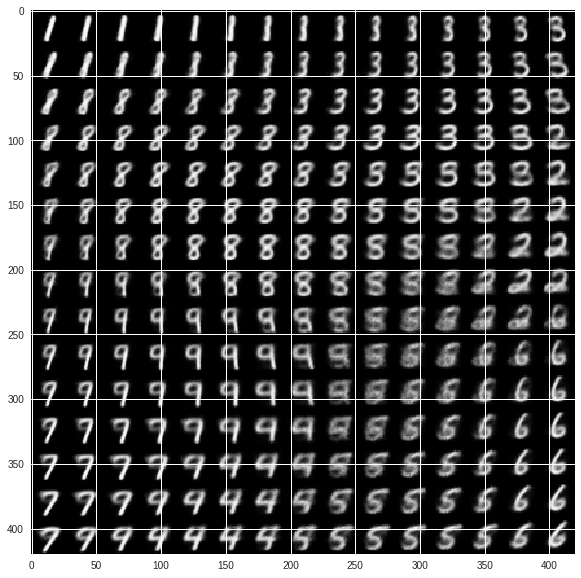

In [8]:
# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

### Conditional VAE

What about producing specific number instances on demand?

We can do this by adding an extra input (as a one-hot encoding) to both the encoder and the decoder:

<center>
<img src="images/vae6.png" alt="" style="width: 400px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

To generate an image of a particular number just feed that number in the decoder along with a random point in the latent space.

<center>
<img src="images/vae7.png" alt="" style="width: 600px;"/> 
(Source: http://ijdykeman.github.io/ml/2016/12/21/cvae.html)
</center>

The latent space is no longer encoding what number are you dealing with (because this is already encoded in the extra input!). Instead, it is encoding information such as stroke width, angle, etc.

## Bibliography

+ Doersch, Carl. “Tutorial on variational autoencoders.” arXiv preprint arXiv:1606.05908 (2016).
+ Kingma, Diederik P., and Max Welling. “Auto-encoding variational bayes.” arXiv preprint arXiv:1312.6114 (2013).